## Plot DUNEX Buoy Data
Based on: http://cdip.ucsd.edu/themes/media/docs/documents/html_pages/compendium.html

In [1]:
import netCDF4
import numpy as np
import xarray as xr
import hvplot.xarray
import datetime
import matplotlib.pyplot as plt
import yaml
from scipy.ndimage.filters import maximum_filter1d
from DUNEX_funcs import nondim_settling_vel, wave_power, calcR2

### Import CDIP buoy data and clip to Sept 1 and later.

In [2]:
stn = '192'
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/' + stn + 'p1_rt.nc'
ds192 = xr.open_dataset(data_url)

stn = '250'
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/' + stn + 'p1_rt.nc'
ds250 = xr.open_dataset(data_url)

stn = '430'
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/' + stn + 'p1_rt.nc'
ds430 = xr.open_dataset(data_url)

print(ds192.metaStationName.values)
print(ds250.metaStationName.values)
print(ds430.metaStationName.values)

# select 9/1 and later
ds192 = ds192.sel(waveTime=slice('2021-09-01 00:00',None))
ds250 = ds250.sel(waveTime=slice('2021-09-01 00:00',None))
ds430 = ds430.sel(waveTime=slice('2021-09-01 00:00',None))

# convert to numpy arrays
t192 = ds192.waveTime.values
Hs192 = ds192.waveHs.values
Tp192 = ds192.waveTp.values
Ta192 = ds192.waveTa.values

t250 = ds250.waveTime.values
Hs250 = ds250.waveHs.values
t430 = ds430.waveTime.values
Hs430 = ds430.waveHs.values

# quick plot
# ds192.waveHs.hvplot(x='waveTime', grid=True)

b'OREGON INLET, NC BUOY - 192p1'
b'CAPE HATTERAS EAST, NC BUOY - 250p1'
b'DUCK FRF 26M, NC BUOY - 430p1'


### Get NOAA water-level data from FRF pier

In [3]:
url9 = 'https://chlthredds.erdc.dren.mil/thredds/dodsC/frf/oceanography/waterlevel/eopNoaaTide/2021/FRF-ocean_waterlevel_eopNoaaTide_202109.nc'
ds9 = xr.open_dataset(url9)
url10 = 'https://chlthredds.erdc.dren.mil/thredds/dodsC/frf/oceanography/waterlevel/eopNoaaTide/2021/FRF-ocean_waterlevel_eopNoaaTide_202110.nc'
ds10 = xr.open_dataset(url10)
dsall = xr.concat([ds9,ds10],dim='time')
wl_time = dsall.time.values
wl_wl = dsall.waterLevel.values
wl_pred = dsall.predictedWaterLevel.values

### A little data analysis
* Interpolate water-levels to wave times
* Calculate run-up and total water level
* Calculate wave power
* Calculate non-dimensional settling velocity
* Calculate quantiles of n-d settling velocity  

Some of the water-level observations are missing, so also calculate TWL for `wl_pred`

In [4]:
### Interpolate water-levels to wave times. The time series are initially datetime64...convert to float first
wli = np.interp( t192.astype('float64'), wl_time.astype('float64'), wl_wl)
wlpi = np.interp( t192.astype('float64'), wl_time.astype('float64'), wl_pred)

R2, _, _, _, _, _, _ = calcR2(Hs192, Tp192, np.arctan(0.02))
TWL = R2+wli
TWLpred = R2+wlpi
maxTWL = maximum_filter1d(TWL, size=25, mode='constant', cval=np.nan)
maxTWLpred = maximum_filter1d(TWLpred, size=25, mode='constant', cval=np.nan)

P, _, _ = wave_power(Hs192,Tp192)
wsnd = nondim_settling_vel(Hs192,Ta192)

# 25% and 75%-iles of non-dim settling velocity
q = np.quantile(wsnd,[.25,.75])

In [49]:
blues = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']
oranges = ['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
greens = ['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purples = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']
grays = ['#f7f7f7','#cccccc','#969696','#636363','#252525']

In [17]:
with open("survey_dates.yml", 'r') as stream:
    survey_dates = yaml.safe_load(stream)
for item in survey_dates:
    print(item)

print('kite: ',survey_dates['kite'])
print('bathy: ',survey_dates['bathy'])
print('foot: ',survey_dates['foot'])
print('aerial:', survey_dates['aerial'])

kite
bathy
foot
sidescan
aerial
kite:  ['2021-09-07', '2021-09-08', '2021-09-11', '2021-09-19', '2021-09-25', '2021-09-26', '2021-10-03', '2021-10-12', '2021-10-19']
bathy:  ['2021-09-06', '2021-09-28', '2021-09-12', '2021-10-19', '2021-10-20']
foot:  ['2021-09-29', '2021-10-11', '2021-10-25']
aerial: ['2021-09-21']


In [52]:
#TODO: this should become an external file that is read in
#   Make a list of dicts with instrument deployment info
insts = [{'name': 'Met. station',     'sd': '2021-09-13 14:04','ed': '2021-10-24 19:51','col':greens[2] },\
         {'name': 'Cameras',          'sd': '2021-09-18 16:00','ed': '2021-10-24 22:00','col':oranges[3] },\
         {'name': 'Pole 0',           'sd': '2021-09-15 18:10','ed': '2021-10-22 14:00','col':blues[2] },\
         {'name': 'Pole 1',           'sd': '2021-09-11 16:00','ed': '2021-10-22 14:00','col':blues[1] },\
         {'name': 'Up. beach press.', 'sd': '2021-09-20 16:40','ed': '2021-10-06 17:18','col':blues[3] },\
         {'name': 'Trough ADV + alt.','sd': '2021-09-14 18:20','ed': '2021-09-26 14:00','col':purples[2]},\
         {'name': 'Trough ADCP',      'sd': '2021-09-14 18:20','ed': '2021-10-21 15:00','col':purples[2] },\
         {'name': 'Bar ADV + alt.',   'sd': '2021-09-14 19:20','ed': '2021-09-28 17:10','col':purples[3] },\
         {'name': 'Bar ADCP',         'sd': '2021-09-14 19:20','ed': '2021-10-21 14:00','col':purples[3] },\
         {'name': 'Offshore ADCP',    'sd': '2021-09-02 14:00','ed': '2021-09-05 14:00','col':purples[4] }]

In [54]:
for inst in insts:
    inst['sdt']=datetime.datetime.strptime(inst['sd'],'%Y-%m-%d %H:%M')
    inst['edt']=datetime.datetime.strptime(inst['ed'],'%Y-%m-%d %H:%M')
    inst['days']=(inst['edt']-inst['sdt']).days
    print(inst['name'], inst['sd'], inst['ed'],inst['days'])

Met. station 2021-09-13 14:04 2021-10-24 19:51 41
Cameras 2021-09-18 16:00 2021-10-24 22:00 36
Pole 0 2021-09-15 18:10 2021-10-22 14:00 36
Pole 1 2021-09-11 16:00 2021-10-22 14:00 40
Up. beach press. 2021-09-20 16:40 2021-10-06 17:18 16
Trough ADV + alt. 2021-09-14 18:20 2021-09-26 14:00 11
Trough ADCP 2021-09-14 18:20 2021-10-21 15:00 36
Bar ADV + alt. 2021-09-14 19:20 2021-09-28 17:10 13
Bar ADCP 2021-09-14 19:20 2021-10-21 14:00 36
Offshore ADCP 2021-09-02 14:00 2021-09-05 14:00 3


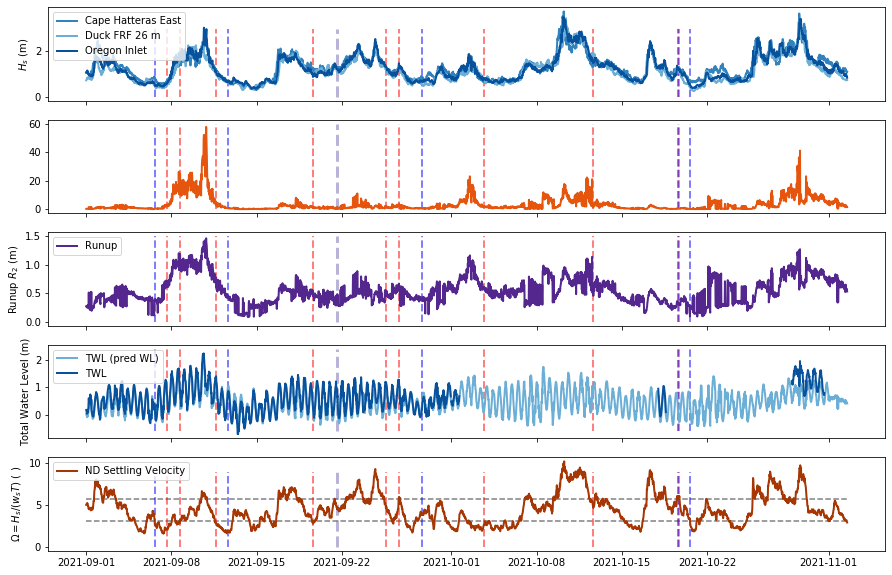

In [71]:
# Create figure and specify subplot orientation (5 rows, 1 column), shared x-axis, and figure size
f, (pHs, pP, pR2, pWL, pWsnd) = plt.subplots(5, 1, sharex=True, figsize=(15,10))

# Significant wave height
for date in survey_dates['kite']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=16)
    pHs.plot([kdt,kdt],[0,3.],'--r',linewidth=2,alpha=.5,zorder=0)
for date in survey_dates['bathy']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pHs.plot([kdt,kdt],[0,3.],'--b',linewidth=2,alpha=.5,zorder=0)
for date in survey_dates['aerial']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pHs.plot([kdt,kdt],[0,3.],'--',c=purples[3],linewidth=3,alpha=.5,zorder=0)

pHs.plot(t250,Hs250,c=blues[3],linewidth=2,label='Cape Hatteras East')
pHs.plot(t430,Hs430,c=blues[2],linewidth=2,label='Duck FRF 26 m')
pHs.plot(t192,Hs192,c=blues[4],linewidth=2,label='Oregon Inlet')
pHs.set_ylabel('$H_s$ (m)')
_ = pHs.legend(loc='upper left')

# Wave power
for date in survey_dates['kite']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=16)
    pP.plot([kdt,kdt],[0,60],'--r',linewidth=2,alpha=.5)
for date in survey_dates['bathy']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pP.plot([kdt,kdt],[0,60],'--b',linewidth=2,alpha=.5)
for date in survey_dates['aerial']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pP.plot([kdt,kdt],[0,60],'--',c=purples[3],linewidth=3,alpha=.5,zorder=1)
pP.plot(t192,P/1e6,c=oranges[3],linewidth=2,label='Wave Power')

# Runup
for date in survey_dates['kite']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=16)
    pR2.plot([kdt,kdt],[0,1.5],'--r',linewidth=2,alpha=.5,zorder=0)
for date in survey_dates['bathy']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pR2.plot([kdt,kdt],[0,1.5],'--b',linewidth=2,alpha=.5,zorder=0)
for date in survey_dates['aerial']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pR2.plot([kdt,kdt],[0,1.5],'--',c=purples[3],linewidth=3,alpha=.5,zorder=1)
pR2.plot(t192,R2,c=purples[4],linewidth=2,label='Runup',zorder=2)
pR2.set_ylabel('Runup $R_2$ (m)')
pR2.legend(loc='upper left')

#Total water level
for date in survey_dates['kite']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=16)
    pWL.plot([kdt,kdt],[-.6,2.4],'--r',linewidth=2,alpha=.5,zorder=0)
for date in survey_dates['bathy']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pWL.plot([kdt,kdt],[-.6,2.4],'--b',linewidth=2,alpha=.5,zorder=0)
for date in survey_dates['aerial']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pWL.plot([kdt,kdt],[-.6,2.4],'--',c=purples[3],linewidth=3,alpha=.5,zorder=1)

pWL.plot(t192,TWLpred,c=blues[2],linewidth=2,label='TWL (pred WL)',zorder=2)
pWL.plot(t192,TWL,c=blues[4],linewidth=2,label='TWL',zorder=3)

#pWL.plot(t192,maxTWL,c=blues[4],linewidth=2,label='max. TWL')
pWL.set_ylabel('Total Water Level (m)')
pWL.legend(loc='upper left')

# Non-dimensional settling velocity
# plot quantiles of non-dim settling velocity
pWsnd.plot( [t192[0],t192[-1]], [q[0],q[0]],'--',c='gray')
pWsnd.plot( [t192[0],t192[-1]], [q[1],q[1]],'--',c='gray')
for date in survey_dates['kite']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=16)
    pWsnd.plot([kdt,kdt],[0,9],'--r',linewidth=2,alpha=.5)
for date in survey_dates['bathy']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pWsnd.plot([kdt,kdt],[0,9],'--b',linewidth=2,alpha=.5)
for date in survey_dates['aerial']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pWsnd.plot([kdt,kdt],[0,9],'--',c=purples[3],linewidth=3,alpha=.5,zorder=1)
pWsnd.plot(t192,wsnd,c=oranges[4],linewidth=2,label='ND Settling Velocity')
_ = pWsnd.set_ylabel('$\Omega=H_s/(w_s T)$ ( )')
_ = pWsnd.legend(loc='upper left')

f.savefig('wave_ts.png')

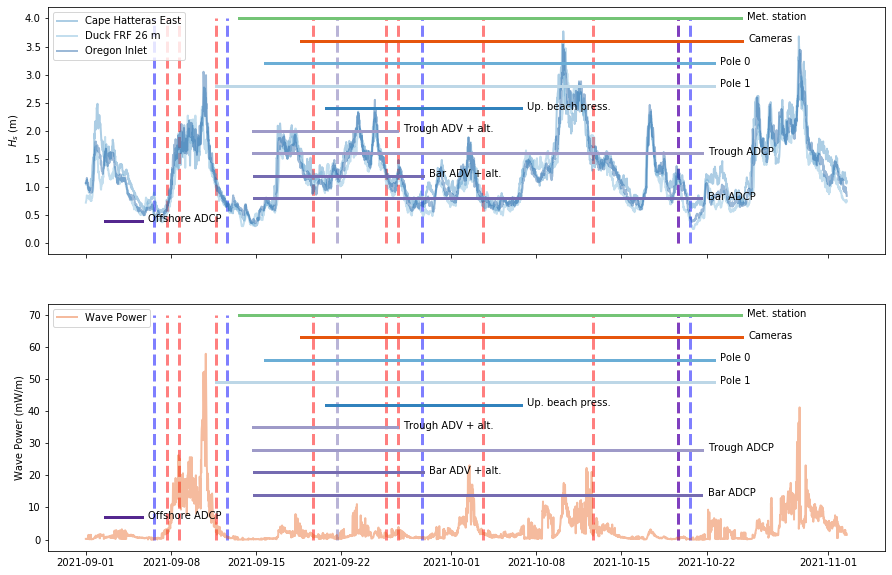

In [70]:
# Create figure and specify subplot orientation (2 rows, 1 column), shared x-axis, and figure size
f, (pHs, pP) = plt.subplots(2, 1, sharex=True, figsize=(15,10))

# Significant wave height
for date in survey_dates['kite']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=16)
    pHs.plot([kdt,kdt],[0,4.],'--r',linewidth=3,alpha=.5,zorder=0)
for date in survey_dates['bathy']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pHs.plot([kdt,kdt],[0,4.],'--b',linewidth=3,alpha=.5,zorder=0)
for date in survey_dates['aerial']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pHs.plot([kdt,kdt],[0,4.],'--',c=purples[3],linewidth=3,alpha=.5,zorder=0)

pHs.plot(t250,Hs250,c=blues[3],linewidth=2,alpha=.4,label='Cape Hatteras East')
pHs.plot(t430,Hs430,c=blues[2],linewidth=2,alpha=.4,label='Duck FRF 26 m')
pHs.plot(t192,Hs192,c=blues[4],linewidth=2,alpha=.4,label='Oregon Inlet')

# instrument durations
fac = .4
for i, inst in enumerate(insts):
    j=len(insts)-i
    pHs.plot([inst['sdt'],inst['edt']],[j*fac,j*fac],'-',c=inst['col'],linewidth=3)
    pHs.text(inst['edt']+datetime.timedelta(days=.5),j*fac-fac/14,inst['name'])
pHs.set_ylabel('Wave Power (mW/m)')
pHs.legend(loc='upper left')
pHs.set_ylabel('$H_s$ (m)')
_ = pHs.legend(loc='upper left')

# Wave power
for date in survey_dates['kite']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=16)
    pP.plot([kdt,kdt],[0,70],'--r',linewidth=3,alpha=.5)
for date in survey_dates['bathy']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pP.plot([kdt,kdt],[0,70],'--b',linewidth=3,alpha=.5)
for date in survey_dates['aerial']:
    kdt = datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(hours=15)
    pP.plot([kdt,kdt],[0,70],'--',c=purples[3],linewidth=3,alpha=.5,zorder=1)
pP.plot(t192,P/1e6,c=oranges[3],linewidth=2,label='Wave Power',alpha=.4)

# instrument durations
fac = 7
for i, inst in enumerate(insts):
    j=len(insts)-i
    pP.plot([inst['sdt'],inst['edt']],[j*fac,j*fac],'-',c=inst['col'],linewidth=3)
    pP.text(inst['edt']+datetime.timedelta(days=.5),j*fac-fac/14.,inst['name'])
pP.set_ylabel('Wave Power (mW/m)')
pP.legend(loc='upper left')

f.savefig('wave_ts_inst_duration.png')